<a href="https://colab.research.google.com/github/bcalik94/Multimodal-Speech-Summarisation-/blob/main/Multimodal_Speech_Summarisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q transformers  rouge-score

     |████████████████████████████████| 4.2 MB 16.0 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
     |████████████████████████████████| 6.6 MB 54.8 MB/s 
     |████████████████████████████████| 596 kB 69.5 MB/s 


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
 
import pandas as pd 
import transformers
from torch.utils.data import Dataset, DataLoader 

from transformers import AutoTokenizer, AutoModel
sentenc_model_name = "sentence-transformers/paraphrase-MiniLM-L3-v2"
tokenizer = AutoTokenizer.from_pretrained(sentenc_model_name)

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from tqdm.notebook import tqdm
import pickle 
import os 
import random
  
sum_dir = "drive/MyDrive/data" 

In [ ]:
F0semitone = ['MEAN:F0semitoneFrom27.5Hz_sma3nz_amean',
 'MEAN:F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'MEAN:F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'MEAN:F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'MEAN:F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'MEAN:F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'MEAN:F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'MEAN:F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'MEAN:F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'MEAN:F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope']



F0semitone += list(map(lambda x: str(x).replace('MEAN:', 'MIN:'), F0semitone)) + list(map(lambda x: str(x).replace('MEAN:', 'MAX:'), F0semitone))
F0semitone.remove('MIN:F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope')
F0semitone.remove('MIN:F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope')
F0semitone.remove('MIN:F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope')



loudness = ['MEAN:loudness_sma3_amean',
 'MEAN:loudness_sma3_stddevNorm',
 'MEAN:loudness_sma3_percentile20.0',
 'MEAN:loudness_sma3_percentile50.0',
 'MEAN:loudness_sma3_percentile80.0',
 'MEAN:loudness_sma3_pctlrange0-2',
 'MEAN:loudness_sma3_meanRisingSlope',
 'MEAN:loudness_sma3_stddevRisingSlope',
 'MEAN:loudness_sma3_meanFallingSlope',
 'MEAN:loudness_sma3_stddevFallingSlope', 
 'MEAN:loudnessPeaksPerSec']

loudness += list(map(lambda x: str(x).replace('MEAN:', 'MIN:'), loudness)) + list(map(lambda x: str(x).replace('MEAN:', 'MAX:'), loudness))


spectral_Flux = ['MEAN:spectralFlux_sma3_amean',
 'MEAN:spectralFlux_sma3_stddevNorm', 
 'MEAN:spectralFluxV_sma3nz_amean',
 'MEAN:spectralFluxV_sma3nz_stddevNorm', 
 'MEAN:spectralFluxUV_sma3nz_amean']

spectral_Flux += list(map(lambda x: str(x).replace('MEAN:', 'MIN:'), spectral_Flux)) + list(map(lambda x: str(x).replace('MEAN:', 'MAX:'), spectral_Flux))

mfcc = ['MEAN:mfcc1_sma3_amean',
 'MEAN:mfcc1_sma3_stddevNorm',
 'MEAN:mfcc2_sma3_amean',
 'MEAN:mfcc2_sma3_stddevNorm',
 'MEAN:mfcc3_sma3_amean',
 'MEAN:mfcc3_sma3_stddevNorm',
 'MEAN:mfcc4_sma3_amean',
 'MEAN:mfcc4_sma3_stddevNorm',
 'MEAN:mfcc1V_sma3nz_amean',
 'MEAN:mfcc1V_sma3nz_stddevNorm',
 'MEAN:mfcc2V_sma3nz_amean',
 'MEAN:mfcc2V_sma3nz_stddevNorm',
 'MEAN:mfcc3V_sma3nz_amean',
 'MEAN:mfcc3V_sma3nz_stddevNorm',
 'MEAN:mfcc4V_sma3nz_amean',
 'MEAN:mfcc4V_sma3nz_stddevNorm']

mfcc += list(map(lambda x: str(x).replace('MEAN:', 'MIN:'), mfcc)) + list(map(lambda x: str(x).replace('MEAN:', 'MAX:'), mfcc))


jitter = ['MEAN:jitterLocal_sma3nz_amean',
 'MEAN:jitterLocal_sma3nz_stddevNorm']

jitter += list(map(lambda x: str(x).replace('MEAN:', 'MIN:'), jitter)) + list(map(lambda x: str(x).replace('MEAN:', 'MAX:'), jitter))


shimmer = ['MEAN:shimmerLocaldB_sma3nz_amean',
 'MEAN:shimmerLocaldB_sma3nz_stddevNorm']

shimmer += list(map(lambda x: str(x).replace('MEAN:', 'MIN:'), shimmer)) + list(map(lambda x: str(x).replace('MEAN:', 'MAX:'), shimmer))


HNR = ['MEAN:HNRdBACF_sma3nz_amean',
 'MEAN:HNRdBACF_sma3nz_stddevNorm']

HNR += list(map(lambda x: str(x).replace('MEAN:', 'MIN:'), HNR)) + list(map(lambda x: str(x).replace('MEAN:', 'MAX:'), HNR))


H1_A3 = ['MEAN:logRelF0-H1-H2_sma3nz_amean',
 'MEAN:logRelF0-H1-H2_sma3nz_stddevNorm',
 'MEAN:logRelF0-H1-A3_sma3nz_amean',
 'MEAN:logRelF0-H1-A3_sma3nz_stddevNorm']

H1_A3 += list(map(lambda x: str(x).replace('MEAN:', 'MIN:'), H1_A3)) + list(map(lambda x: str(x).replace('MEAN:', 'MAX:'), H1_A3))


F1 = ['MEAN:F1frequency_sma3nz_stddevNorm',
 'MEAN:F1bandwidth_sma3nz_amean',
 'MEAN:F1bandwidth_sma3nz_stddevNorm',
 'MEAN:F1amplitudeLogRelF0_sma3nz_amean',
 'MEAN:F1amplitudeLogRelF0_sma3nz_stddevNorm']

F1 += list(map(lambda x: str(x).replace('MEAN:', 'MIN:'), F1)) + list(map(lambda x: str(x).replace('MEAN:', 'MAX:'), F1))


F2 = ['MEAN:F2frequency_sma3nz_amean',
 'MEAN:F2frequency_sma3nz_stddevNorm',
 'MEAN:F2bandwidth_sma3nz_amean',
 'MEAN:F2bandwidth_sma3nz_stddevNorm',
 'MEAN:F2amplitudeLogRelF0_sma3nz_amean',
 'MEAN:F2amplitudeLogRelF0_sma3nz_stddevNorm']

F2 += list(map(lambda x: str(x).replace('MEAN:', 'MIN:'), F2)) + list(map(lambda x: str(x).replace('MEAN:', 'MAX:'), F2))


F3 = ['MEAN:F3frequency_sma3nz_amean',
 'MEAN:F3frequency_sma3nz_stddevNorm',
 'MEAN:F3bandwidth_sma3nz_amean',
 'MEAN:F3bandwidth_sma3nz_stddevNorm',
 'MEAN:F3amplitudeLogRelF0_sma3nz_amean',
 'MEAN:F3amplitudeLogRelF0_sma3nz_stddevNorm']

F3 += list(map(lambda x: str(x).replace('MEAN:', 'MIN:'),F3)) + list(map(lambda x: str(x).replace('MEAN:', 'MAX:'), F3))


alphaRatio = ['MEAN:alphaRatioV_sma3nz_amean',
 'MEAN:alphaRatioV_sma3nz_stddevNorm',
 'MEAN:alphaRatioUV_sma3nz_amean']

alphaRatio  += list(map(lambda x: str(x).replace('MEAN:', 'MIN:'), alphaRatio )) + list(map(lambda x: str(x).replace('MEAN:', 'MAX:'), alphaRatio ))

hammarberg = ['MEAN:hammarbergIndexV_sma3nz_amean',
 'MEAN:hammarbergIndexV_sma3nz_stddevNorm', 
 'MEAN:hammarbergIndexUV_sma3nz_amean']

hammarberg += list(map(lambda x: str(x).replace('MEAN:', 'MIN:'), hammarberg)) + list(map(lambda x: str(x).replace('MEAN:', 'MAX:'), hammarberg))


slopeV = ['MEAN:slopeV0-500_sma3nz_amean',
 'MEAN:slopeV0-500_sma3nz_stddevNorm',
 'MEAN:slopeV500-1500_sma3nz_amean',
 'MEAN:slopeV500-1500_sma3nz_stddevNorm', 
 'MEAN:slopeUV0-500_sma3nz_amean',
 'MEAN:slopeUV500-1500_sma3nz_amean']

slopeV  += list(map(lambda x: str(x).replace('MEAN:', 'MIN:'), slopeV )) + list(map(lambda x: str(x).replace('MEAN:', 'MAX:'), slopeV ))

Segments = ['MEAN:VoicedSegmentsPerSec',
 'MEAN:MeanVoicedSegmentLengthSec',
 'MEAN:StddevVoicedSegmentLengthSec',
 'MEAN:MeanUnvoicedSegmentLength',
 'MEAN:StddevUnvoicedSegmentLength',
 'MEAN:equivalentSoundLevel_dBp']

Segments += list(map(lambda x: str(x).replace('MEAN:', 'MIN:'), Segments)) + list(map(lambda x: str(x).replace('MEAN:', 'MAX:'), Segments))
#Remove features which have 0 stds
Segments.remove('MIN:VoicedSegmentsPerSec')
Segments.remove('MIN:StddevVoicedSegmentLengthSec')
Segments.remove('MIN:StddevUnvoicedSegmentLength')
Segments.remove('MIN:MeanUnvoicedSegmentLength')
Segments.remove('MAX:MeanVoicedSegmentLengthSec')



LLDs ={'F0semitone':F0semitone, 'loudness': loudness, 'spectral_Flux': spectral_Flux, 'mfcc': mfcc,'jitter': jitter,'shimmer': shimmer,'HNR':HNR ,'H1_A3': H1_A3, 'F1': F1, 'F2': F2,'F3' :F3,'alphaRatio': alphaRatio, 'hammarberg': hammarberg, 'slopeV': slopeV, 'Segments': Segments  }

In [ ]:
LLDs ={'F0semitone':F0semitone, 'loudness': loudness, 'spectral_Flux': spectral_Flux, 'mfcc': mfcc,'jitter': jitter,'shimmer': shimmer,'HNR':HNR ,'H1_A3': H1_A3, 'F1': F1, 'F2': F2,'F3' :F3,'alphaRatio': alphaRatio, 'hammarberg': hammarberg, 'slopeV': slopeV, 'Segments': Segments  }

In [ ]:

def flatten(xss):
    return [x for xs in xss for x in xs]

all_features = flatten(list(LLDs.values()))

In [ ]:
#Selected acoustic features for the model
acoustic_cols = F0semitone

In [ ]:
test_ids = [1199, 1173, 765, 656, 1604, 2260, 42, 1702, 794, 1466, 6, 2600, 165, 471, 2854, 3074, 2559, 1470, 9, 2880, 2549, 2752, 23, 3342, 2963, 2671, 2819, 2378, 27, 566, 747, 3244, 2961, 1070, 2371, 373, 667, 2942, 1442, 3197, 177, 3293, 299, 2787, 2915, 3199, 827, 847, 100, 1253, 415, 3312, 793, 19, 1676, 2936, 1346, 575, 1308, 797, 1612, 3195, 921, 1276, 2270, 244, 131, 3154, 3118, 1508, 1190, 3298, 2896, 2461, 1263, 1471, 1342, 931, 505, 3305, 1029, 2034, 289, 3271, 151, 1092, 3158, 3167, 2983, 3322, 3110, 3200, 3114, 2921, 2431, 1035, 569, 499, 2334, 3327, 837, 833, 890, 2297, 654, 939, 2560, 431, 675, 3287, 376, 2602, 2672, 1251, 559, 2298, 789, 64, 1265, 492, 2953, 1191, 1765, 1428, 1332, 3086, 954, 2848, 2163, 411, 2673, 1282, 370, 1158, 313, 74, 2948, 1338, 329, 1219, 3329, 1175, 2857, 2950, 812, 841, 2335, 715, 778, 3071, 634, 170, 2871, 2068, 2191, 1269, 347, 208, 359, 3060, 1217, 2758, 3155, 288, 900, 730, 2990, 902, 3235, 2524, 906, 3356, 2694, 3065, 238, 1319, 3187, 281, 3174, 3191, 2033, 12, 2835, 2668, 2565, 508, 2864, 1153, 2566, 1038, 1312, 3208, 2870, 2030, 2941, 748, 587, 2769, 306, 2434]


In [ ]:
print(test_ids)

[1199, 1173, 765, 656, 1604, 2260, 42, 1702, 794, 1466, 6, 2600, 165, 471, 2854, 3074, 2559, 1470, 9, 2880, 2549, 2752, 23, 3342, 2963, 2671, 2819, 2378, 27, 566, 747, 3244, 2961, 1070, 2371, 373, 667, 2942, 1442, 3197, 177, 3293, 299, 2787, 2915, 3199, 827, 847, 100, 1253, 415, 3312, 793, 19, 1676, 2936, 1346, 575, 1308, 797, 1612, 3195, 921, 1276, 2270, 244, 131, 3154, 3118, 1508, 1190, 3298, 2896, 2461, 1263, 1471, 1342, 931, 505, 3305, 1029, 2034, 289, 3271, 151, 1092, 3158, 3167, 2983, 3322, 3110, 3200, 3114, 2921, 2431, 1035, 569, 499, 2334, 3327, 837, 833, 890, 2297, 654, 939, 2560, 431, 675, 3287, 376, 2602, 2672, 1251, 559, 2298, 789, 64, 1265, 492, 2953, 1191, 1765, 1428, 1332, 3086, 954, 2848, 2163, 411, 2673, 1282, 370, 1158, 313, 74, 2948, 1338, 329, 1219, 3329, 1175, 2857, 2950, 812, 841, 2335, 715, 778, 3071, 634, 170, 2871, 2068, 2191, 1269, 347, 208, 359, 3060, 1217, 2758, 3155, 288, 900, 730, 2990, 902, 3235, 2524, 906, 3356, 2694, 3065, 238, 1319, 3187, 281, 3174, 31

In [ ]:
pickle_off = open ("/content/drive/MyDrive/data/ZNormedperSpeaker_MinMax_2000.txt", "rb")
LLD_LDA_df = pickle.load(pickle_off).sort_values('sentence_id').reset_index(drop = True)

sents_df = LLD_LDA_df.dropna().iloc[:-95,:]


#Split the dataset to train, val and test

train_df = sents_df[sents_df['doc_id'].isin(test_ids)==False]
test_df = sents_df[sents_df['doc_id'].isin(test_ids)]

print('train-val-test')
print(len(train_df), len(test_df))
print( "Train,val, test shape ", train_df.shape,test_df.shape)
print("Total number of episodes in all sets:" + str(len(train_df.groupby('episode_id'))))
print("Total number of episodes in valid sets:" + str(len(test_df.groupby('episode_id'))))
train_df



train-val-test
180312 21188
Train,val, test shape  (180312, 269) (21188, 269)
Total number of episodes in all sets:1797
Total number of episodes in valid sets:200


,sentence_id,doc_id,show_name,episode_id,Description,Transcript,speakerTag,sentence,MEAN:F0semitoneFrom27.5Hz_sma3nz_amean,MEAN:F0semitoneFrom27.5Hz_sma3nz_stddevNorm,...,MAX:loudnessPeaksPerSec,MAX:VoicedSegmentsPerSec,MAX:MeanVoicedSegmentLengthSec,MAX:StddevVoicedSegmentLengthSec,MAX:MeanUnvoicedSegmentLength,MAX:StddevUnvoicedSegmentLength,MAX:equivalentSoundLevel_dBp,rouge_score,label_range_perdoc,label_score
0,193,2,the very good podcast,spotify:episode:3ThCh3ko96O186PYt5qmHi,presenting 'the very good podcast' from atlant...,I love the idea of Family Worship. Where can ...,2,Where can I go from your spirit?,0.665731,0.312944,...,0.35428,0.239604,0.50284,0.418275,0.261946,0.18456,0.447316,0.043478,"(-0.001, 0.114]",0
1,194,2,the very good podcast,spotify:episode:3ThCh3ko96O186PYt5qmHi,presenting 'the very good podcast' from atlant...,I love the idea of Family Worship. Where can ...,1,It's in our DNA well said Welcome to the very ...,0.524198,0.384716,...,0.182739,0.458173,0.498848,0.40157,0.327867,0.258871,0.607354,0.214286,"(0.114, 0.297]",1
2,196,2,the very good podcast,spotify:episode:3ThCh3ko96O186PYt5qmHi,presenting 'the very good podcast' from atlant...,I love the idea of Family Worship. Where can ...,1,I'm the director of communications for Atlanta...,0.48395,0.342908,...,0.401123,0.380141,0.400818,0.586189,0.298218,0.227037,0.629176,0.2,"(0.114, 0.297]",1
3,197,2,the very good podcast,spotify:episode:3ThCh3ko96O186PYt5qmHi,presenting 'the very good podcast' from atlant...,I love the idea of Family Worship. Where can ...,1,"If you're listening, you're already aware that...",0.501101,0.335223,...,0.255533,0.302108,0.51237,0.470993,0.327867,0.220715,0.66295,0.067797,"(-0.001, 0.114]",0
4,198,2,the very good podcast,spotify:episode:3ThCh3ko96O186PYt5qmHi,presenting 'the very good podcast' from atlant...,I love the idea of Family Worship. Where can ...,1,Our goal is to give you dear listener relevant...,0.448958,0.361516,...,0.401123,0.302108,0.51237,0.552308,0.321937,0.25124,0.649609,0.075949,"(-0.001, 0.114]",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201495,836832,3376,fey-sci and friends,spotify:episode:3URF7VVSis1hlobvBVGTbD,what a ridiculous and utterly obsolete questio...,"Hello, here. We are again to podcast Chris me...",2,"Yeah, and we still don't know how they were el...",0.488243,0.451111,...,0.421156,0.461796,0.520431,0.646035,0.327299,0.318624,0.603083,0.138889,"(0.125, 0.18]",1
201496,836854,3376,fey-sci and friends,spotify:episode:3URF7VVSis1hlobvBVGTbD,what a ridiculous and utterly obsolete questio...,"Hello, here. We are again to podcast Chris me...",2,"Priest tell me so yeah, the priests have to go...",0.454126,0.471909,...,0.357091,0.381407,0.520431,0.544885,0.365689,0.395519,0.664662,0.07874,"(-0.001, 0.125]",0
201497,836861,3376,fey-sci and friends,spotify:episode:3URF7VVSis1hlobvBVGTbD,what a ridiculous and utterly obsolete questio...,"Hello, here. We are again to podcast Chris me...",2,Can you dial it back just a bit?,0.355234,0.389385,...,0.228961,0.461796,0.358289,0.281229,0.306581,0.311698,0.423454,0.04,"(-0.001, 0.125]",0
201498,836866,3376,fey-sci and friends,spotify:episode:3URF7VVSis1hlobvBVGTbD,what a ridiculous and utterly obsolete questio...,"Hello, here. We are again to podcast Chris me...",2,So you saying if you would at the perfect we d...,0.50331,0.526492,...,0.421156,0.461796,0.520431,0.561743,0.327299,0.329609,0.651744,0.180451,"(0.125, 0.18]",1


We need to normalize the acoustic values per episode, per speaker and globally

In [ ]:

#train_df.groupby('doc_id').agg(['mean', 'min', 'max', 'count', 'median' ])

#pd.DataFrame(train_df.groupby('doc_id')[mean_cols].agg([ 'min', 'max'])).T.reset_index(level=[0,1])

#train_df[all_acoustic_cols] = train_df.groupby('show_name')[all_acoustic_cols].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

#test_df[all_acoustic_cols] = test_df.groupby('show_name')[all_acoustic_cols].transform(lambda x: (x - x.min()) / (x.max() - x.min()))


# **Create a Data Loader Class**
Create a dataloader class that yields sentences and documentss and labels.

Setting hyperparameters for the model

In [ ]:

num_extra_dims = len(acoustic_cols)
print_n_steps = 1000
EPOCHS = 5
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
TEST_BATCH_SIZE = 4
LEARNING_RATE = 2e-05 
acc_step_holder, loss_step_holder = [], []
acc_val_holder, loss_val_holder = [], []

fpr_list = []
tpr_list = []


model_name="sentence-transformers/paraphrase-MiniLM-L3-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)



In [ ]:
# Create a Data Loader Class
class SpotifyPodcastData(Dataset):
    def __init__(self, dataframe, tokenizer, acoustic_cols, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.acoustic_cols = acoustic_cols
        
    def __getitem__(self, index):
        sentence = str(self.data.iloc[index].sentence)
        sentence = " ".join(sentence.split())

        document = str(self.data.iloc[index].Transcript)
        document = " ".join(document.split())

        acoustics_info = np.stack(self.data[acoustic_cols].iloc[index].values).astype(np.float64) 

        inputs = self.tokenizer.batch_encode_plus(
            [sentence, document], 
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'sent_ids': torch.tensor(ids[0], dtype=torch.long),
            'doc_ids': torch.tensor(ids[1], dtype=torch.long),
            'sent_mask': torch.tensor(mask[0], dtype=torch.long),
            'doc_mask': torch.tensor(mask[1], dtype=torch.long),
            'acoustics' : torch.from_numpy(acoustics_info),
            'targets': torch.tensor([self.data.iloc[index].label_score], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len


testing_set = SpotifyPodcastData(test_df, tokenizer,acoustic_cols, MAX_LEN)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

#testing_loader = DataLoader(testing_set, **test_params)



testing_set[0]['acoustics'].size()


torch.Size([27])

In [ ]:
pd.DataFrame(train_df.groupby(['show_name','doc_id']).size())

0
show_name                                  doc_id     
#5things                                   2072     59
#dobetter pod                              320      87
                                           321     156
                                           322     143
#the100dayproject: explore your creativity 2523     58
...                                                ...
wizards weekly musings                     1605     57
write night                                2010     65
year round disc golf                       1537     76
yoga daily                                 3124     67
                                           3125    178

[1797 rows x 1 columns]

In [ ]:

from sklearn.metrics import recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import accuracy_score, roc_curve, auc

def flat_torch(listlist):

 outputs = []
 for ttorch in listlist:
    #print(ttorch.flatten().tolist())
    outputs.extend(ttorch.flatten().tolist())
 return outputs

 
def plotAUC(fpr, tpr, roc_auc): 

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# **Build Model**
Build model based on sentence Bert pretrained models.

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the `[CLS]` token is used as the features of the sequence to feed a classifier.

The `transformers` library has the [`BertForSequenceClassification`](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification) class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the `[CLS]` token and a single-hidden-layer feed-forward neural network as our classifier.

In [ ]:
# get mean pooling for sentence bert models 
# ref https://www.sbert.net/examples/applications/computing-embeddings/README.html#sentence-embeddings-with-transformers
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 
# Note that different sentence transformer models may have different in_feature sizes

#Dropout is only used during the training of a model and is not used when evaluating the skill of the model
class SentenceBertClass(torch.nn.Module):
    def __init__(self,model_name, num_extra_dims, in_features=384):
        """
        @param    bert: a BertModel object
        @param    MLP classifier: a torch.nn.Module MLP classifier for acoustic and BERT embeddings
        """
        super(SentenceBertClass, self).__init__()
        self.l1 = AutoModel.from_pretrained(model_name)

        self.MLPclassifier = nn.Sequential(
            nn.Linear(in_features*3+num_extra_dims, 768),
            nn.ReLU(),
            #nn.BatchNorm1d(768),
            #nn.ReLU(),
            nn.Dropout(0.2),
            torch.nn.Linear(768, 1),
            #nn.BatchNorm1d(1),
            torch.nn.Sigmoid()
        )

    def forward(self, sent_ids, doc_ids, sent_mask, doc_mask, acoustic_info):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """

        sent_output = self.l1(input_ids=sent_ids, attention_mask=sent_mask) 
        sentence_embeddings = mean_pooling(sent_output, sent_mask) 

        doc_output = self.l1(input_ids=doc_ids, attention_mask=doc_mask) 
        doc_embeddings = mean_pooling(doc_output, doc_mask)

        # elementwise product of sentence embs and doc embs
        combined_features = sentence_embeddings * doc_embeddings  

        # get concat of both features and elementwise product
        feat_cat = torch.cat((sentence_embeddings, doc_embeddings, combined_features, acoustic_info), dim=1)   
        
        output = self.MLPclassifier(feat_cat) 
        
        #output = self.classifier(feat_cat)
        return output

# Initialize the model

To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

Batch size: 8 or 16
Learning rate (Adam): 5e-5, 3e-5 or 2e-5
Number of epochs: 2, 3, 4

In [ ]:
from torch import cuda
from transformers import AdamW, get_linear_schedule_with_warmup

device = 'cuda' if cuda.is_available() else 'cpu'
# Instantiate Bert Classifier
model = SentenceBertClass(model_name=model_name, num_extra_dims=len(acoustic_cols))

# Tell PyTorch to run the model on GPU
model.to(device);

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

loss_function = torch.nn.BCELoss()


Downloading:   0%|          | 0.00/66.4M [00:00<?, ?B/s]

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model
import random
import time
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(epoch):
   # =======================================
   #               Training
   # =======================================
   # Print the header of the result table
    print('-'*100)
    #print(f"Epoch: {epoch}")
    # print(f"{'Epoch':^7} | {'Batch':^7} | {'Train':^12} | {'Validation':^9}")
    print('-'*100)

        # Measure the elapsed time of each epoch
    t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
    total_loss, batch_loss, batch_counts = 0, 0, 0

    predictions, true_labels = [],[]
    all_logits = []
    target_list = []
    roc_auc_list = []


    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    #broc_auc  = 0 


    model.train()

    t0 = time.time()
    for _,data in tqdm(enumerate(training_loader, 0)):
        batch_counts +=1

        # Load batch to GPU
        sent_ids = data['sent_ids'].to(device, dtype = torch.long)
        doc_ids = data['doc_ids'].to(device, dtype = torch.long)
        sent_mask = data['sent_mask'].to(device, dtype = torch.long)
        doc_mask = data['doc_mask'].to(device, dtype = torch.long) 
        targets = data['targets'].to(device, dtype = torch.float) 
        acoustic_info = data['acoustics'].to(device, dtype = torch.float)

        # Zero out any previously calculated gradients
        #model.zero_grad()

        # Perform a forward pass. This will return logits.
        outputs = model(sent_ids, doc_ids, sent_mask, doc_mask,acoustic_info) 

        # Compute loss and accumulate the loss values
        loss = loss_function(outputs, targets)
        batch_loss += loss.item()
        total_loss += loss.item()

        tr_loss += loss.item() 
        n_correct += torch.count_nonzero(targets == (outputs > 0.5)).item()

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
   
        # Move logits and labels to CPU
        logits = outputs.detach().cpu().numpy()
        batch_targets = targets.to('cpu').numpy()


        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(batch_targets)


        
        if _%print_n_steps==0:

           # Calculate time elapsed for 20 batches
            time_elapsed = time.time() - t0_batch
            # Report progress.
            #print('  Step {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(_, len(training_loader), time_elapsed))

            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            bfpr, btpr, bthreshold = roc_curve(np.asarray(flat_torch(batch_targets)), np.where(np.asarray(flat_torch(logits)) > 0.5, 1, 0))
            broc_auc = auc(bfpr, btpr)
            
            print('  Step {:}  of  {:}  Accuracy {:} Loss -> {:}.  AUC -> {:}.'.format(_*TRAIN_BATCH_SIZE, (len(training_loader)*TRAIN_BATCH_SIZE), accu_step, loss_step,broc_auc))
      
            
            #print(str(_* train_params["batch_size"]) + 'Batch_AUC:' + str(broc_auc))
            roc_auc_list.append(broc_auc)
            fpr_list.append(bfpr)
            tpr_list.append(btpr) 
            acc_step_holder.append(accu_step)
            loss_step_holder.append(loss_step)
       
       
        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()


    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")
 
    fpr = 0
    tpr = 0
    accuracy = 0
    roc_auc = 0 
    sensitivity = 0 
    specificity = 0 
    F1 = 0

    # Combine the results across all batches.  
    flat_predictions = flat_torch(predictions)

    # For each sample, pick the label (0 or 1) with the higher score.

    flat_predictions = np.where(np.asarray(flat_predictions) > 0.5, 1, 0)

    # Combine the correct labels for each batch into a single list.

    flat_true_labels =  np.asarray(flat_torch(true_labels))

    #Accuracy 

    good_preds = 0

    for i in range(len(flat_predictions)):

        if (flat_predictions[i] == flat_true_labels[i]) == True:

            good_preds += 1

    accuracy = good_preds/len(flat_predictions)

  
    
    fpr, tpr, threshold = roc_curve(flat_true_labels, flat_predictions)
    roc_auc = auc(fpr, tpr)
    

    # 0 label is our positive label (Dominant disturbance)
    sensitivity = recall_score(flat_true_labels, flat_predictions)
    specificity = 1 - fpr
    Matthews_Cor = matthews_corrcoef(flat_true_labels, flat_predictions)
    F1_score = f1_score(flat_true_labels, flat_predictions)
    print(f'AUC: {roc_auc:.4f}')
    print('F1 score per Training Fold: ', f1_score(flat_true_labels, flat_predictions))
    print('Sensitivity per Training Fold: ', recall_score(flat_true_labels, flat_predictions))
    print('Specificity per Training Fold: ', (1 - fpr[1]) )
    print('Matthews Cor. Coef. per Training Fold: ', matthews_corrcoef(flat_true_labels, flat_predictions))
    print('Training per Fold is done!')
    #plotAUC(fpr, tpr, roc_auc)
    print('-'*100)

    return 

In [ ]:
import torch.nn.functional as F

def model_validate(model, validating_loader):
    print('-'*100)
    print('Validation per Fold')
    
    
    predictions, true_labels = [],[]
    all_logits = []
    target_list = []
    total_eval_loss = 0
    nb_val_steps = 0
    batch_loss = 0
    total_loss = 0

    val_loss = 0
    valn_correct = 0
    nb_val_steps = 0
    nb_val_examples = 0

    # Measure the elapsed time of each epoch
    t0_batch = time.time()


    t0 = time.time()
    model.eval()
# For each batch in our test set...    
    for _, data in enumerate(validating_loader, 0): 
            # Load batch to GPU   
            sent_ids = data['sent_ids'].to(device, dtype = torch.long)
            doc_ids = data['doc_ids'].to(device, dtype = torch.long)
            sent_mask = data['sent_mask'].to(device, dtype = torch.long)
            doc_mask = data['doc_mask'].to(device, dtype = torch.long) 
            targets = data['targets'].to(device, dtype = torch.float) 
            acoustic_info = data['acoustics'].to(device, dtype = torch.float)

            # Compute logits
            with torch.no_grad():
              outputs = model(sent_ids, doc_ids, sent_mask, doc_mask,acoustic_info) 
           
                   # Compute loss and accumulate the loss values

                    # Compute loss and accumulate the loss values
            loss = loss_function(outputs, targets)
            batch_loss += loss.item()
            total_loss += loss.item()

            val_loss += loss.item() 
            valn_correct += torch.count_nonzero(targets == (outputs > 0.5)).item()

            nb_val_steps += 1
            nb_val_examples +=targets.size(0)
      
            # Move logits and labels to CPU
            logits = outputs.detach().cpu().numpy()
            batch_targets = targets.to('cpu').numpy()

            
            if _%print_n_steps==0:

              # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                # Report progress.
                #print('  Bat {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(_, len(validating_loader), time_elapsed))

                loss_step = val_loss/nb_val_steps
                accu_step = (valn_correct*100)/nb_val_examples 
                #bfpr, btpr, bthreshold = roc_curve(np.asarray(flat_torch(batch_targets)), np.where(np.asarray(flat_torch(logits)) > 0.5, 1, 0))
                #broc_auc = auc(bfpr, btpr)
                acc_val_holder.append(accu_step)
                loss_val_holder.append(loss_step)

                
                print('  Batch {:}.  of  {:}.  Acc -> {:}. Loss -> {:}.'.format(_*VALID_BATCH_SIZE, len(validating_loader)*VALID_BATCH_SIZE, accu_step, loss_step))


            # Store predictions and true labels
            predictions.append(logits)
            true_labels.append(batch_targets)
    
    

    return predictions, true_labels

In [ ]:
# Compute predicted probabilities on the set

roc_auc_list = []
tpr_list = []
fpe_list = []
def calculate_predictions(predictions, true_labels):

  fpr = 0
  tpr = 0
  accuracy = 0
  roc_auc = 0 
  sensitivity = 0 
  specificity = 0 
  F1 = 0


 
  # Combine the results across all batches.  
  flat_predictions = flat_torch(predictions)

  # For each sample, pick the label (0 or 1) with the higher score.

  flat_predictions = np.where(np.asarray(flat_predictions) > 0.5, 1, 0)

  # Combine the correct labels for each batch into a single list.

  flat_true_labels =  np.asarray(flat_torch(true_labels))

  #Accuracy 

  good_preds = 0

  for i in range(len(flat_predictions)):

      if (flat_predictions[i] == flat_true_labels[i]) == True:

          good_preds += 1

  accuracy = good_preds/len(flat_predictions)

 
  
  fpr, tpr, threshold = roc_curve(flat_predictions, flat_true_labels)
  roc_auc = auc(fpr, tpr)
  tpr_list.append(tpr)
  fpr_list.append(fpr)
  
  roc_array = roc_auc_score(flat_true_labels, flat_predictions, average=None)
  roc_auc_list.append(roc_auc)

  # 0 label is our positive label (Dominant disturbance)
  sensitivity = recall_score(flat_true_labels, flat_predictions)
  specificity = 1 - fpr
  Matthews_Cor = matthews_corrcoef(flat_true_labels, flat_predictions)
  F1_score = f1_score(flat_true_labels, flat_predictions)

  print(f'AUC of Validation Fold: {roc_auc:.4f}')
  print('F1 score of Validation Fold: ', f1_score(flat_true_labels, flat_predictions))
  print('Sensitivity of Validation Fold: ', recall_score(flat_true_labels, flat_predictions))
  print('Specificity of Validation Fold: ', (1 - fpr[1]) )
  print('Accuracy of Validation Fold: ' + str(accuracy))
  print('Matthews Cor. Coef. of Validation Fold: ', matthews_corrcoef(flat_true_labels, flat_predictions))
  
  print('Validation per Fold is done!')
  print('-'*100)
  print('-'*100)
  plotAUC(fpr, tpr, roc_auc)

  return accuracy, roc_auc, sensitivity, specificity, F1, tpr_list, fpr_list, roc_auc_list


In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 59 different named parameters.

==== Embedding Layer ====

l1.embeddings.word_embeddings.weight                    (30522, 384)
l1.embeddings.position_embeddings.weight                  (512, 384)
l1.embeddings.token_type_embeddings.weight                  (2, 384)
l1.embeddings.LayerNorm.weight                                (384,)
l1.embeddings.LayerNorm.bias                                  (384,)

==== First Transformer ====

l1.encoder.layer.0.attention.self.query.weight            (384, 384)
l1.encoder.layer.0.attention.self.query.bias                  (384,)
l1.encoder.layer.0.attention.self.key.weight              (384, 384)
l1.encoder.layer.0.attention.self.key.bias                    (384,)
l1.encoder.layer.0.attention.self.value.weight            (384, 384)
l1.encoder.layer.0.attention.self.value.bias                  (384,)
l1.encoder.layer.0.attention.output.dense.weight          (384, 384)
l1.encoder.layer.0.attention.output.dense.bias                (3

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
model

SentenceBertClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=Tr

In [ ]:
set_seed(42)    # Set seed for reproducibility

Epoch 0 is ready to go!
Epoch:0 is training...
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


0it [00:00, ?it/s]

  Step 0  of  144256  Accuracy 31.25 Loss -> 0.7018322944641113.  AUC -> 0.6333333333333333.
  Step 16000  of  144256  Accuracy 76.81068931068931 Loss -> 0.47778440877929196.  AUC -> 0.8076923076923077.
  Step 32000  of  144256  Accuracy 77.96414292853574 Loss -> 0.45811399258952445.  AUC -> 0.9166666666666667.
  Step 48000  of  144256  Accuracy 78.33013995334889 Loss -> 0.4525935969370399.  AUC -> 0.7619047619047619.
  Step 64000  of  144256  Accuracy 78.51162209447638 Loss -> 0.44939285063298157.  AUC -> 0.5416666666666667.
  Step 80000  of  144256  Accuracy 78.61677664467106 Loss -> 0.4475191193425138.  AUC -> 0.26666666666666666.
  Step 96000  of  144256  Accuracy 78.77749541743043 Loss -> 0.44541872202744187.  AUC -> 0.4.
  Step 112000  of  144256  Accuracy 78.9342593915155 Loss -> 0.44289035675841015.  AUC -> 0.8125.
  Step 128000  of  144256  Accuracy 79.07370953630796 Loss -> 0.4394894803655012.  AUC -> 0.8545454545454545.
  Step 144000  of  144256  Accuracy 79.18564603932896 L

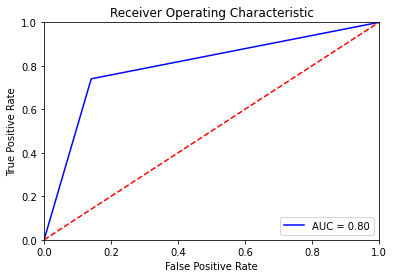

Epoch 0 is done!
Epoch 1 is ready to go!
Epoch:1 is training...
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


0it [00:00, ?it/s]

  Step 0  of  144256  Accuracy 81.25 Loss -> 0.31475794315338135.  AUC -> 0.7545454545454545.
  Step 16000  of  144256  Accuracy 80.83166833166833 Loss -> 0.3986801765598617.  AUC -> 1.0.
  Step 32000  of  144256  Accuracy 81.30934532733633 Loss -> 0.39327224415132606.  AUC -> 0.5333333333333333.
  Step 48000  of  144256  Accuracy 81.42702432522492 Loss -> 0.39236540239588574.  AUC -> 0.9090909090909091.
  Step 64000  of  144256  Accuracy 81.47025743564109 Loss -> 0.3912400546646869.  AUC -> 0.9166666666666667.
  Step 80000  of  144256  Accuracy 81.5374425114977 Loss -> 0.3888870055879075.  AUC -> 0.75.
  Step 96000  of  144256  Accuracy 81.6270204965839 Loss -> 0.3875617043432882.  AUC -> 0.8015873015873016.
  Step 112000  of  144256  Accuracy 81.73653763748035 Loss -> 0.38520673767249425.  AUC -> 0.8.
  Step 128000  of  144256  Accuracy 81.82180352455943 Loss -> 0.38324702363109725.  AUC -> 0.9.
  Step 144000  of  144256  Accuracy 81.90617709143429 Loss -> 0.38170057945901215.  AUC -

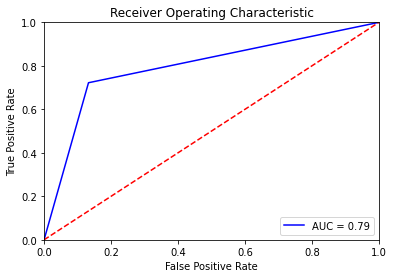

Epoch 1 is done!
Epoch 2 is ready to go!
Epoch:2 is training...
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


0it [00:00, ?it/s]

  Step 0  of  144256  Accuracy 75.0 Loss -> 0.5459859371185303.  AUC -> 0.6666666666666666.
  Step 16000  of  144256  Accuracy 82.992007992008 Loss -> 0.3560996889308854.  AUC -> 0.9166666666666667.
  Step 32000  of  144256  Accuracy 83.13968015992003 Loss -> 0.35370891544593686.  AUC -> 0.6746031746031746.
  Step 48000  of  144256  Accuracy 83.24100299900033 Loss -> 0.3541179558672495.  AUC -> 0.5416666666666667.
  Step 64000  of  144256  Accuracy 83.34947513121719 Loss -> 0.3527550864708674.  AUC -> 0.9375.
  Step 80000  of  144256  Accuracy 83.3245850829834 Loss -> 0.35205420960538675.  AUC -> 0.8333333333333333.
  Step 96000  of  144256  Accuracy 83.26528911848025 Loss -> 0.35277819110291975.  AUC -> 0.9375.
  Step 112000  of  144256  Accuracy 83.285423510927 Loss -> 0.3532802817925072.  AUC -> 0.7090909090909091.
  Step 128000  of  144256  Accuracy 83.35208098987627 Loss -> 0.35170756839611517.  AUC -> 0.9545454545454545.
  Step 144000  of  144256  Accuracy 83.4094822797467 Loss -

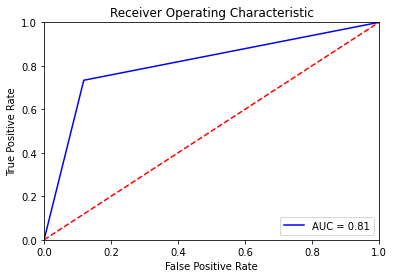

Epoch 2 is done!
Epoch 3 is ready to go!
Epoch:3 is training...
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


0it [00:00, ?it/s]

  Step 0  of  144256  Accuracy 81.25 Loss -> 0.33666253089904785.  AUC -> 0.8090909090909091.
  Step 16000  of  144256  Accuracy 84.95879120879121 Loss -> 0.3329412822837715.  AUC -> 0.9090909090909091.
  Step 32000  of  144256  Accuracy 84.82633683158421 Loss -> 0.3301583391161396.  AUC -> 1.0.
  Step 48000  of  144256  Accuracy 84.6988503832056 Loss -> 0.33092062106503123.  AUC -> 0.8015873015873016.
  Step 64000  of  144256  Accuracy 84.62415646088478 Loss -> 0.33098126748533463.  AUC -> 0.875.
  Step 80000  of  144256  Accuracy 84.67056588682263 Loss -> 0.3307762226088718.  AUC -> 0.9.
  Step 96000  of  144256  Accuracy 84.6161056490585 Loss -> 0.33164083993801413.  AUC -> 0.5181818181818182.
  Step 112000  of  144256  Accuracy 84.60041422653907 Loss -> 0.33101222614418896.  AUC -> 0.7000000000000001.
  Step 128000  of  144256  Accuracy 84.62926509186352 Loss -> 0.3312707463131072.  AUC -> 0.873015873015873.
  Step 144000  of  144256  Accuracy 84.67948005777136 Loss -> 0.3307921134

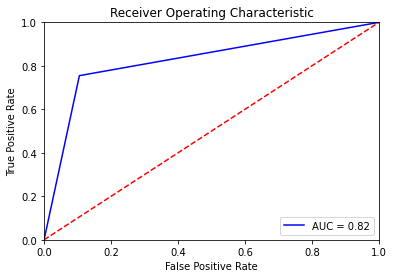

Epoch 3 is done!
Epoch 4 is ready to go!
Epoch:4 is training...
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


0it [00:00, ?it/s]

  Step 0  of  144256  Accuracy 93.75 Loss -> 0.18352270126342773.  AUC -> 0.9615384615384616.
  Step 16000  of  144256  Accuracy 84.96503496503496 Loss -> 0.3266319269528398.  AUC -> 0.7833333333333333.
  Step 32000  of  144256  Accuracy 84.93565717141429 Loss -> 0.3259537080707757.  AUC -> 0.7063492063492064.
  Step 48000  of  144256  Accuracy 84.99875041652783 Loss -> 0.3251204993681326.  AUC -> 0.8166666666666668.
  Step 64000  of  144256  Accuracy 84.94282679330168 Loss -> 0.3276937135696128.  AUC -> 0.6636363636363637.
  Step 80000  of  144256  Accuracy 84.84178164367127 Loss -> 0.3294541788684311.  AUC -> 0.8545454545454545.
  Step 96000  of  144256  Accuracy 84.84627562072988 Loss -> 0.3296844138354286.  AUC -> 1.0.
  Step 112000  of  144256  Accuracy 84.7932438223111 Loss -> 0.33055897608852747.  AUC -> 0.8666666666666667.
  Step 128000  of  144256  Accuracy 84.78471441069867 Loss -> 0.33006063576588895.  AUC -> 0.8166666666666668.
  Step 144000  of  144256  Accuracy 84.7718309

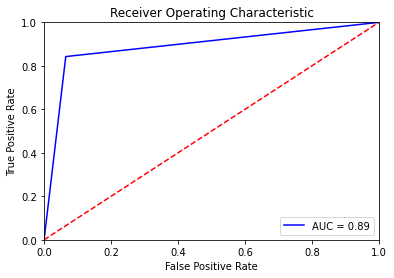

Epoch 4 is done!


In [ ]:
from sklearn.model_selection import KFold
EPOCHS = 5
n = EPOCHS 
kf = KFold(n_splits=n, shuffle=False)


    #print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Acc':^7} | {'Train Loss':^7} | {'AUC':^7}")
    #print("-"*70)
i = 0
for train_index, val_index in kf.split(train_df):
            print("Epoch " + str(i) + " is ready to go!")
            train_data = train_df.iloc[train_index]
            val_data = train_df.iloc[val_index]
            training_set = SpotifyPodcastData(train_data, tokenizer,acoustic_cols, MAX_LEN)
            validating_set = SpotifyPodcastData(val_data, tokenizer,acoustic_cols, MAX_LEN)
            training_loader = DataLoader(training_set, **train_params)
            validating_loader = DataLoader(validating_set, **val_params)
            print('Epoch:' + str(i) + " is training...")
            train(i)
            predictions, true_labels = model_validate(model, validating_loader)
            accuracy, roc_auc, sensitivity, specificity, F1, tpr_list, fpr_list, roc_auc_list = calculate_predictions(predictions, true_labels)
            print("Epoch " + str(i) + " is done!")
            i = i+1


In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# method II: ggplot
from ggplot import *
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

AttributeError: ignored

In [ ]:




[i[1] for i in tpr_list] , [i[1] for i in fpr_list]

In [ ]:
fpr_list

In [ ]:
plt.plot(roc_auc_list)
def plotAUC( fpr,tpr, roc_auc): 

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(roc_auc_list, label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
from sklearn import metrics

fpr, tpr, _ = roc_curve(predictions,  true_labels)

plot()

In [ ]:
roc_auc_list

In [ ]:
np.array([0.7997499517229167,
 0.7873580152937472,
 0.7638047393173404,
 0.7939893417843207,
 0.8519636190251272]).mean()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(32,10))
ax1.plot(acc_step_holder, label="Accuracy")
ax2.plot(loss_step_holder, label="Loss")
ax1.title.set_text("Accuracy")
ax2.title.set_text("Loss")
fig.tight_layout()
plt.show()

[0.48536265]

In [ ]:
import os 

os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/Multimodal_SentenceBERT_MLP_1Epoch_5KFold_1600_MinMax_250522.pth")
!gsutil cp -r models $sum_dir